# Проект: классификация

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(
    lambda x: 
        float(x.replace(' ', '')
              .replace(',', '.')
              [:-1]) 
        if type(x) != float 
        else x)

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [7]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

### Задание 6

In [9]:
# удалите все выбросы для признака balance
def remove_outliers (data, feature):
    x = data[feature]
    quant1 = x.quantile(0.25)
    quant2 = x.quantile(0.75)
    iqr = quant2 - quant1
    lower_bound = quant1 - 1.5 * iqr
    upper_bound = quant2 + 1.5 * iqr
    return data[((x >= lower_bound) & (x <= upper_bound))]

df = remove_outliers(df,'balance')    

## Часть 2:  Разведывательный анализ

### Задание 1

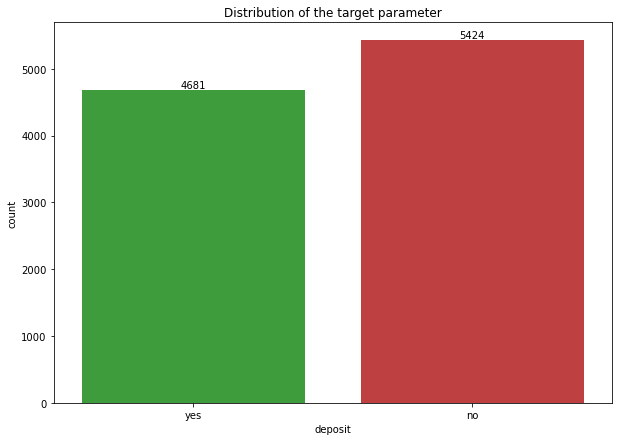

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig, ax = plt.subplots(figsize = (10,7))
palette = ['#0fcc0d','red']
sns.countplot(x = df['deposit'], palette=palette, saturation = 0.5)
ax.set_title('Distribution of the target parameter')
ax.bar_label(ax.containers[0]);

Классы достаточно сбалансированы.

### Задания 2 и 3

In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


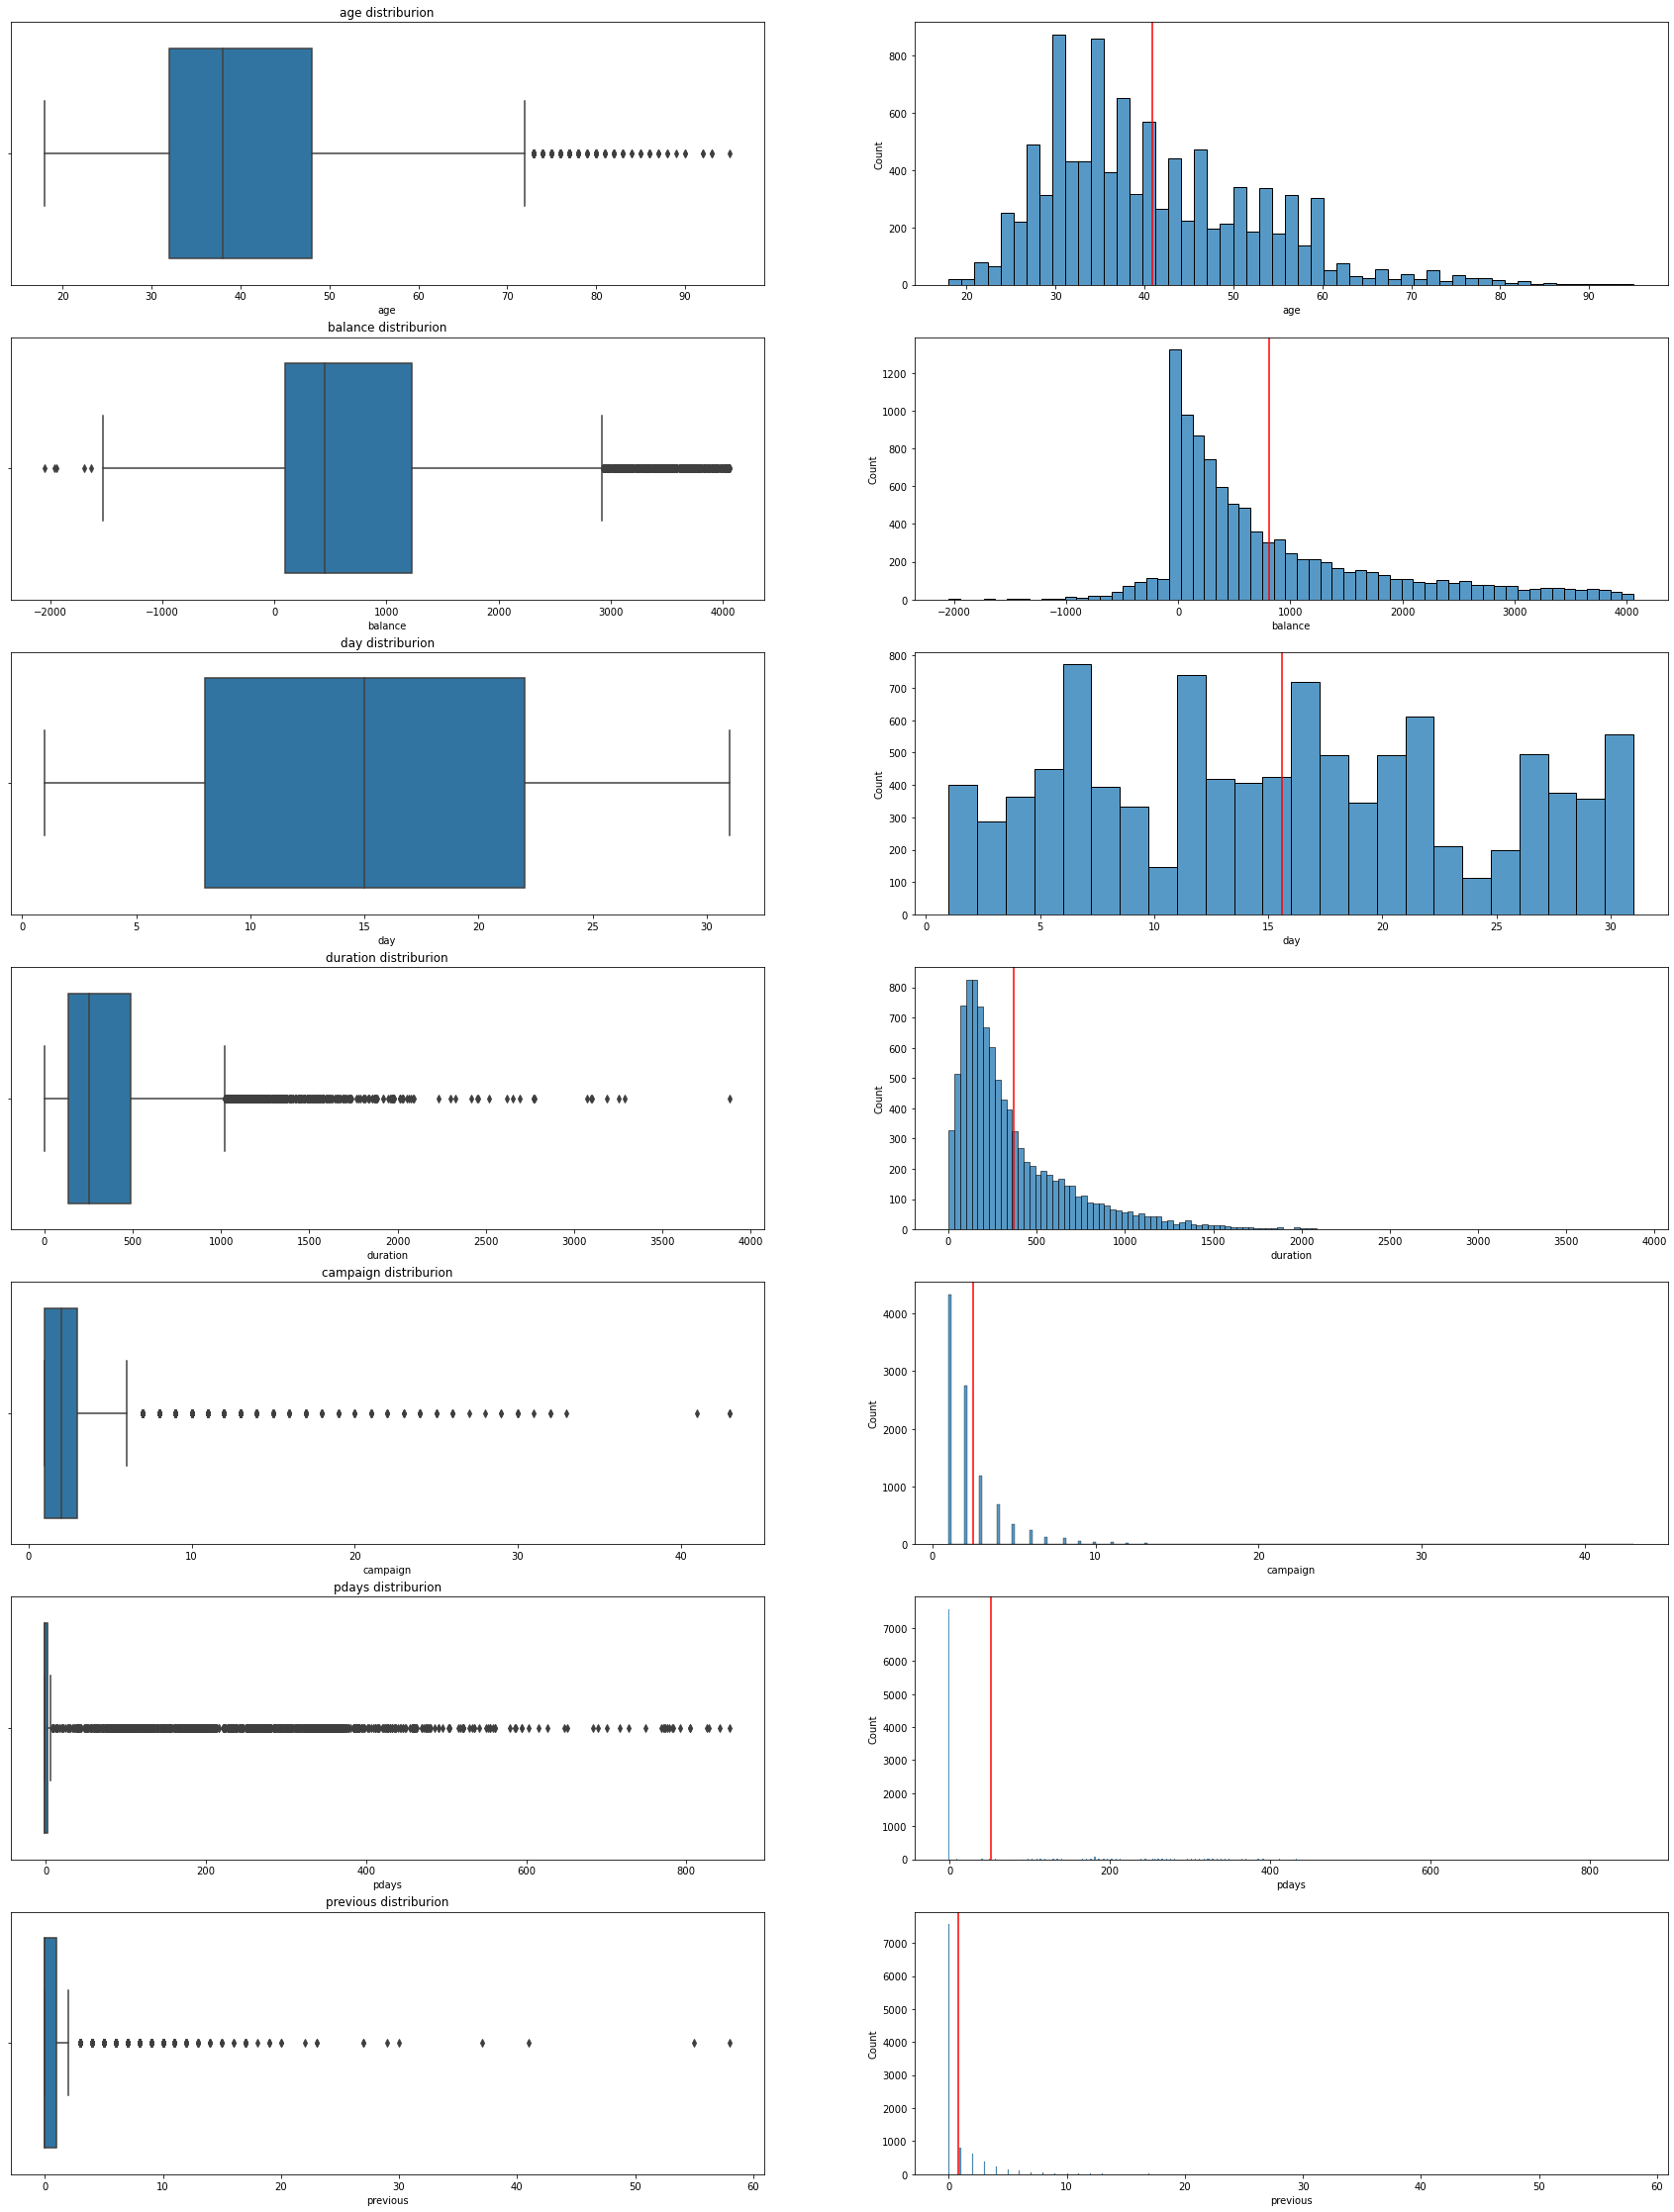

In [12]:
numeric_columns = df.select_dtypes(include = np.number).columns.to_list()
fig, ax = plt.subplots(len(numeric_columns), 2, figsize = (30,40))
for count, column in enumerate(numeric_columns):
    sns.boxplot(ax = ax[count,0], x = df[column])
    ax[count,1].axvline(df[column].mean(), color = 'red')
    sns.histplot(ax = ax[count,1], x = df[column])
    ax[count,0].set_title(f"{column} distriburion")

Данные распределены достаточно равномерно по дню, когда был произведен последний контакт. Распределения по возрасту, балансу и продолжительности разговора похожи на логнормальные. Количество пропущенных дней с прошлой компании и количество контактов с клиентом до текущей компании практически полностью сконцентрированы на одном значении (около 75% принимают значения -1 и 0 соответственно). 

Аномальными значениями можно считать: баланс менее -1500, более 10 контактов в течение кампании, длительность контакта более 2000.

### Задания 4 и 5

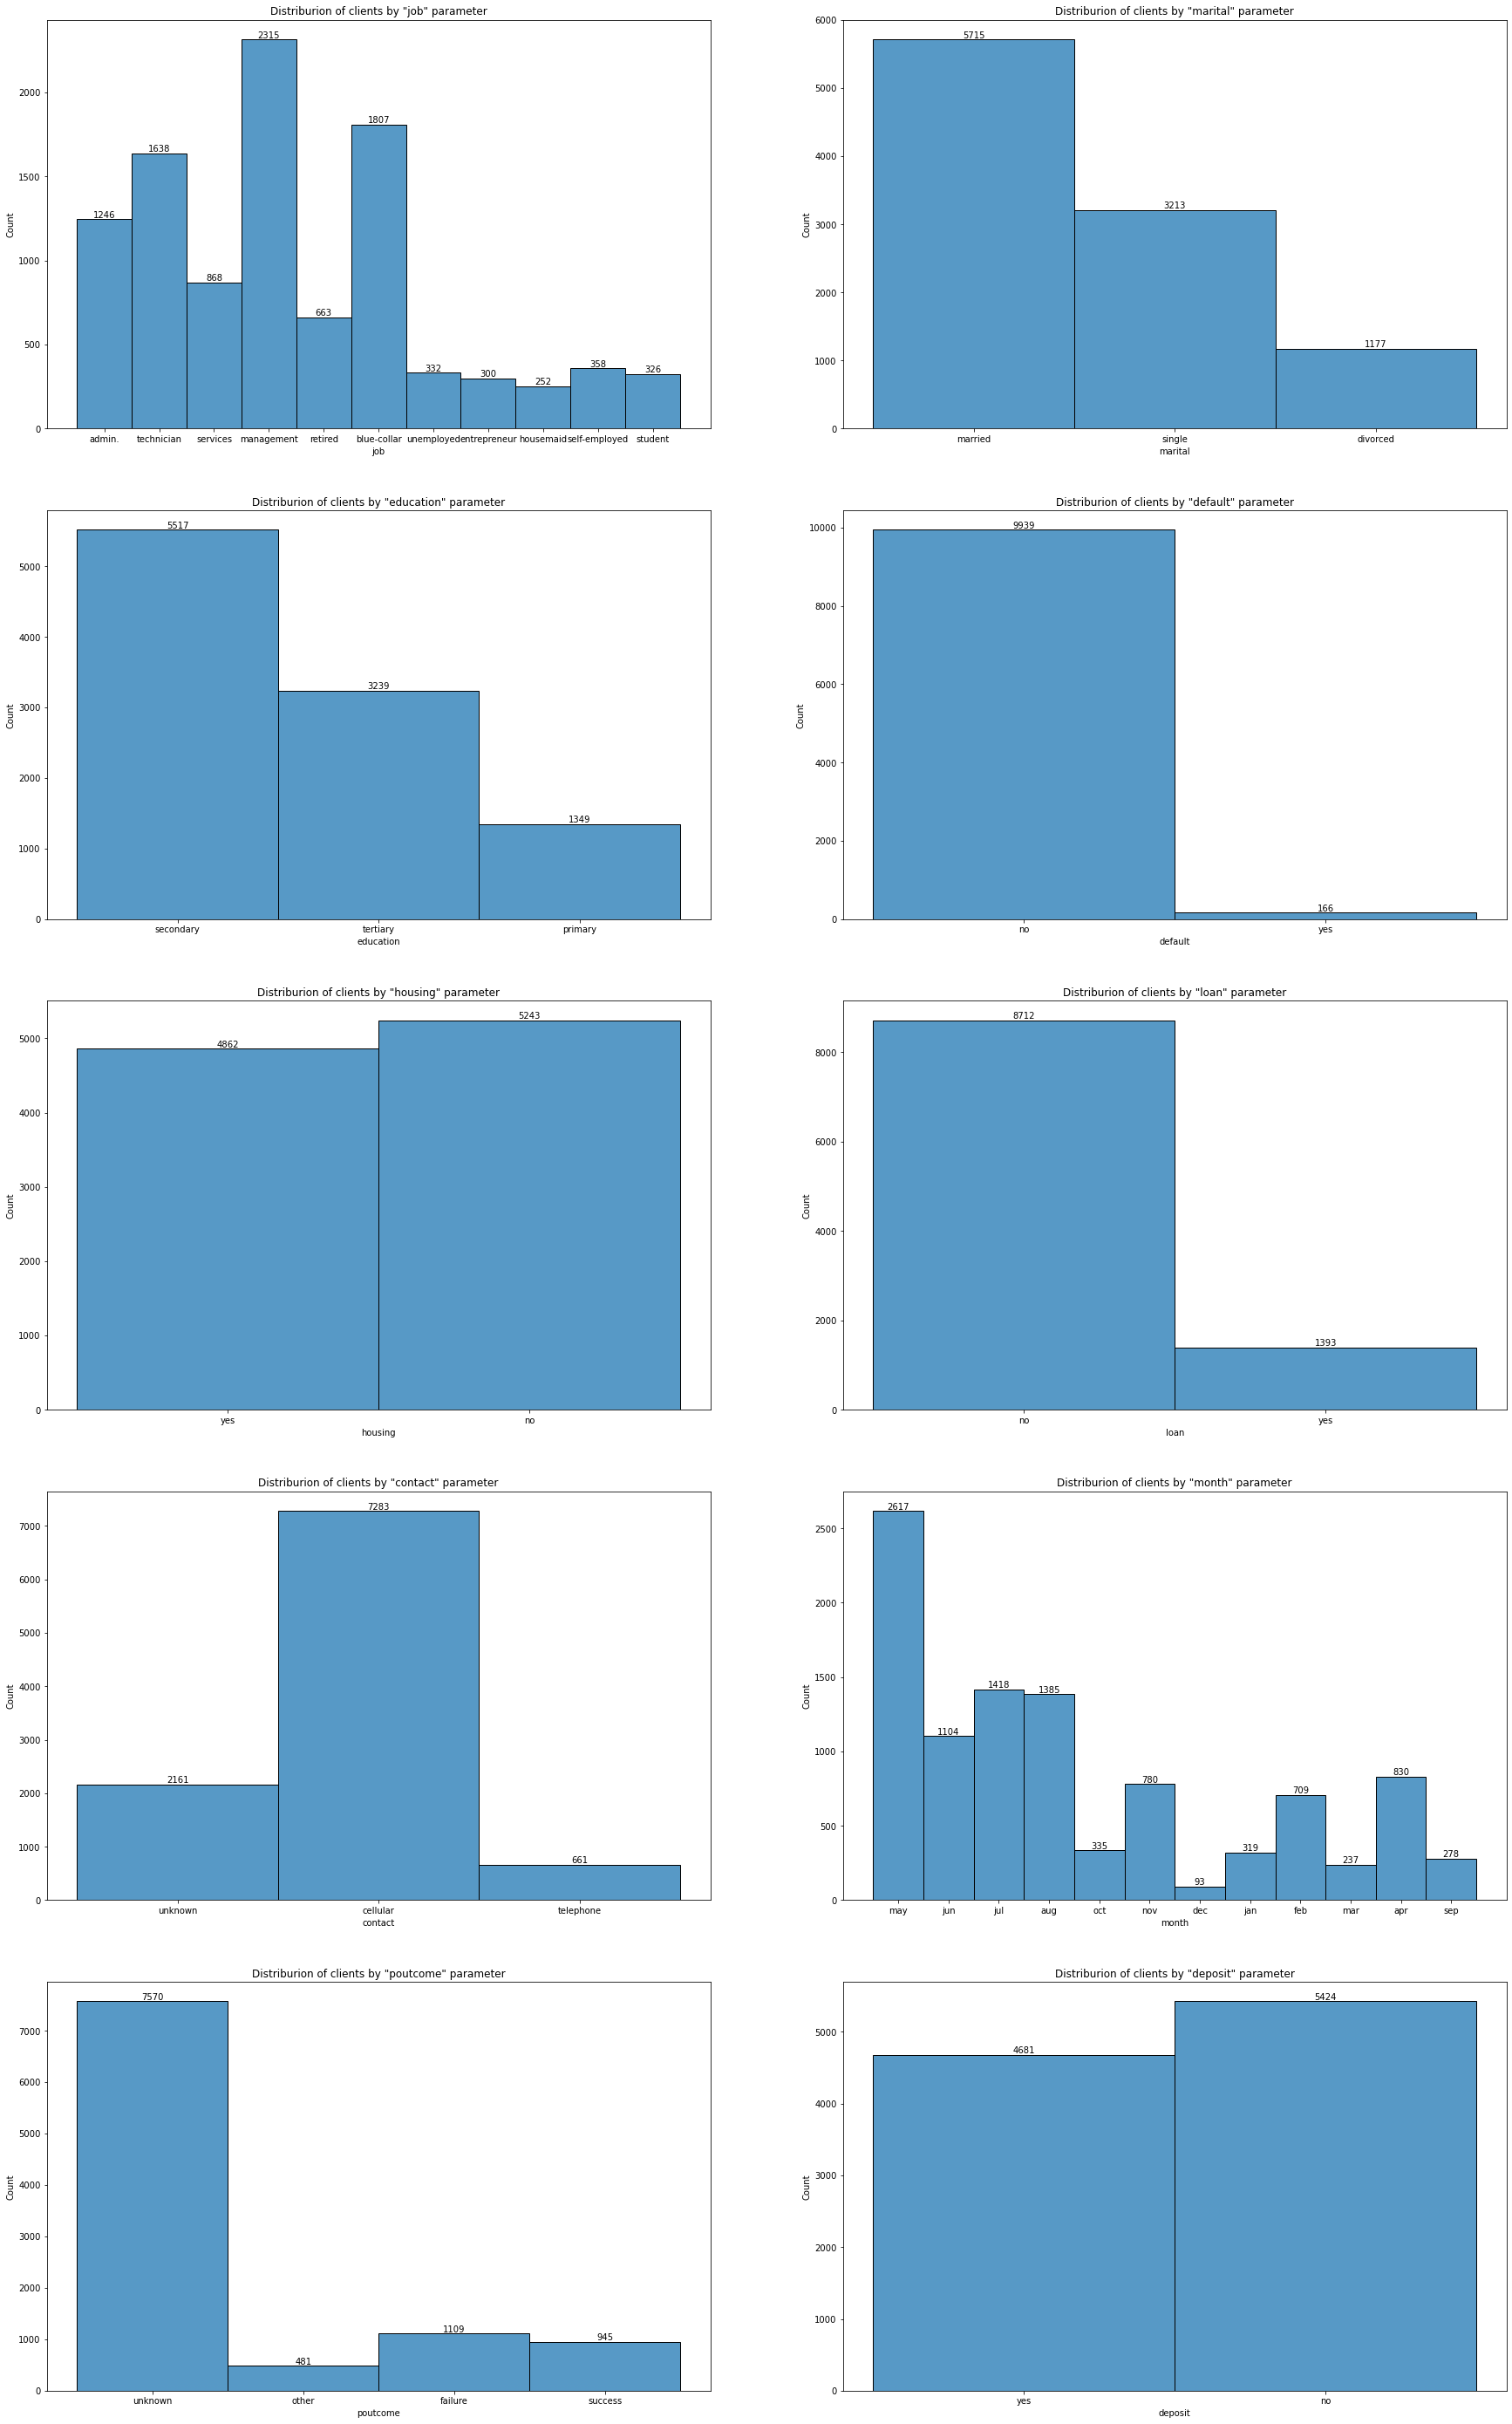

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты
categorial_columns = df.select_dtypes(exclude = np.number).columns.to_list()
fig, ax = plt.subplots(int((len(categorial_columns)+1)/2), 2, figsize = (30,50))
for count, column in enumerate(categorial_columns):
    if count%2 == 0:
        sns.histplot(ax = ax[int(count/2),0], x = df[column])
        ax[int(count/2),0].set_title(f"Distriburion of clients by \"{column}\" parameter")
        ax[int(count/2),0].bar_label(ax[int(count/2),0].containers[0])
    else:
        sns.histplot(ax = ax[int((count-1)/2),1], x = df[column])
        ax[int((count-1)/2),1].set_title(f"Distriburion of clients by \"{column}\" parameter")
        ax[int((count-1)/2),1].bar_label(ax[int((count-1)/2),1].containers[0])


Топ-3 сферы занятости среди клиентов банка это мэнеджмент, "синие воротнички" и техники.

Примерно половина клиентов состоит в браке.

Также половина клиентов имеют среднее образование, около 30% - высшее, а остальные - начальное.

Практически у всех клиентов не имеется просроченных кредитов и взятых кредитов на личные нужды.

Около половины клиентов имеют открытый кредит на жилье.

Контакт с клиентом чаще всего происходит по мобильному телефону. Практически ни с кем не свзяываются по стационарному телефону.

С клиентами чаще всего связвылись в последний раз в мае, а реже всего в декабр, марте и сентябре.

Для ~75% клиентов неизвестен результат прошлой маркетинговой кампании (большинство из них скорее всего в ней не участвовали, если сопоставить их количество с числом клиентов, у которых число пропущенных дней с прошлой кампании равно -1).

Не считая группу "Other", видим, что прошлая кампания была успешной чуть менее чем в половине случаев.

### Задание 6

In [14]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby(['poutcome'])['deposit'].value_counts(normalize=True)

poutcome  deposit
failure   no         0.506763
          yes        0.493237
other     yes        0.550936
          no         0.449064
success   yes        0.911111
          no         0.088889
unknown   no         0.602642
          yes        0.397358
Name: deposit, dtype: float64

Практически все клиенты успешно участвовавшие в прошлой кампании решили участвовать и в этой (говорит об удовлетворенности клиентов результатами предыдущей кампании). Около половины клиентов, не участвовавших в прошлый раз изменили свое решение в этой кампании (неплохой процент).

### Задание 7

In [15]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby(['month'])['deposit'].value_counts(normalize=True).sort_values(ascending=False)

month  deposit
dec    yes        0.903226
mar    yes        0.898734
sep    yes        0.834532
oct    yes        0.814925
may    no         0.678640
apr    yes        0.618072
jan    no         0.608150
jul    no         0.589563
nov    no         0.584615
aug    no         0.559567
jun    no         0.548913
feb    yes        0.544429
       no         0.455571
jun    yes        0.451087
aug    yes        0.440433
nov    yes        0.415385
jul    yes        0.410437
jan    yes        0.391850
apr    no         0.381928
may    yes        0.321360
oct    no         0.185075
sep    no         0.165468
mar    no         0.101266
dec    no         0.096774
Name: deposit, dtype: float64

Видим, что среди участвующих клиентов в месяцах май, январь, июль, ноябрь, август и июнь более половины решали не открывать депозит (67% отказов в мае). Несложно заметить, что 4 из этих 5 месяцев идут подряд. Возможно, стоит пересмотреть проведение кампании в период с мая по август включительно.

### Задание 8

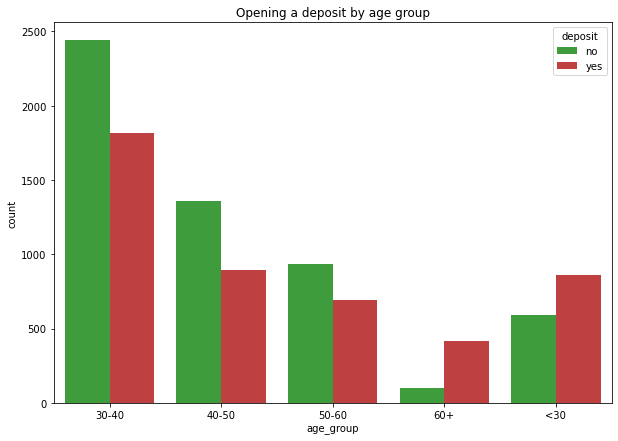

In [16]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = df['age'].apply(lambda x: 
    '<30' if x < 30 else 
    ('30-40'if x <= 40 else
     ('40-50' if x <= 50 else
      ('50-60' if x <= 60 else
       '60+'))) )

fig = plt.figure(figsize=(10, 7))
sns.countplot(data = df.sort_values(by = 'age_group'), x = 'age_group', hue='deposit', palette = palette, saturation=0.5).set_title('Opening a deposit by age group');

Несколько больше клиентов открывают депозиты, чем отказываются в группе "до 30 лет". Также большинство клиентов старше 60 лет открывают депозиты.

Клиенты в возрасте от 30 до 60 менее склонны открывать депозиты, поэтому следует учесть это в планировании маркетинговой кампании, учитывая, что в этой группе находится большинство клиентов банка.

### Задания 9 и 10

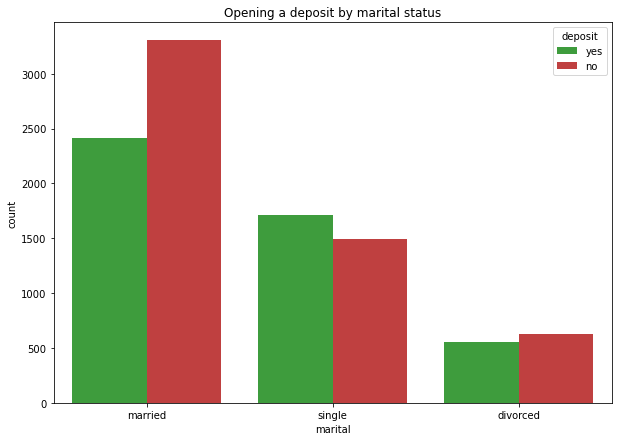

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(10, 7))
sns.countplot(data = df, x = 'marital', hue='deposit', palette = palette, saturation=0.5).set_title('Opening a deposit by marital status');

Большинство клиентов находятся в браке и менее склонны открывать депозиты. Меньшинство отноится к группе "разведенные" и у них наблюдается примерно одинаковое соотношение открывших и не открывших депозиты с небольим перевесом в сторону последних.

Группа не состоящих в браке является самой благосклонной к открытию депозита в банке, однако и в этой группе процент открывающих депозит не очень высок.

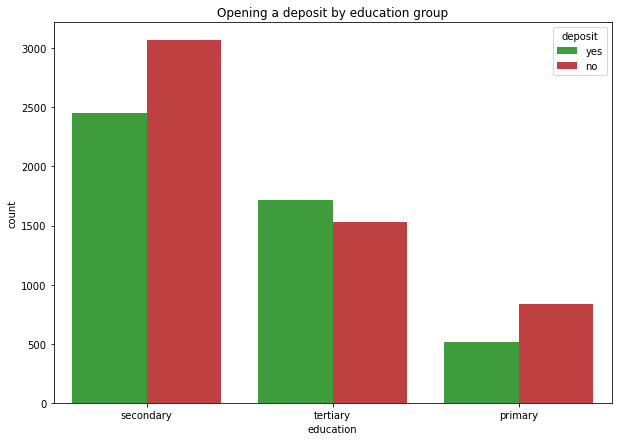

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(10, 7))
sns.countplot(data = df, x = 'education', hue='deposit', palette = palette, saturation=0.5).set_title('Opening a deposit by education group');

Видим, что большинство клиентов не имеет высшего образования и проявляют тенденцию к отклонению предлодения об открытии депозита. В то же время клиенты с высшим образованием склонны это предложение принимать (процент все еще не очень хороший).

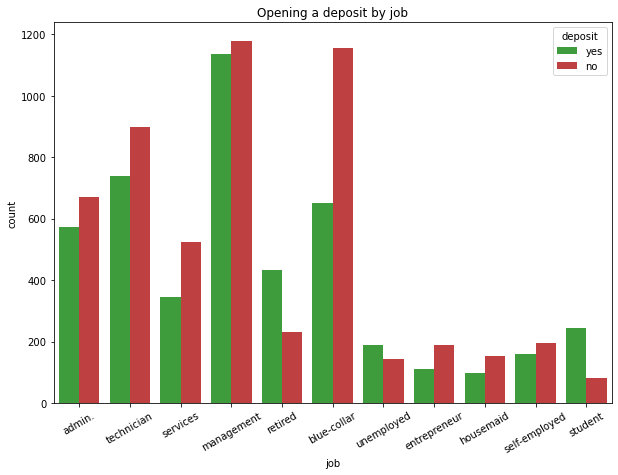

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax= plt.subplots(figsize=(10, 7))
sns.countplot(data = df, ax = ax, x = 'job', hue='deposit', palette = palette, saturation=0.5).set_title('Opening a deposit by job')
plt.xticks(rotation = 30);

Можем сделать вывод, что самые склонные к открытию депозитов группы клиентов это студенты, безработные и вышедшие на пенсию люди.

В то же время с большим отрывом худшей группой являются "синие воротнички". Эта группа также является довольно многочисленной, поэтому стоит обратить внимание на эффективность кампании по отношению к этой группе клиентов.

### Задание 11

<AxesSubplot:xlabel='education', ylabel='marital'>

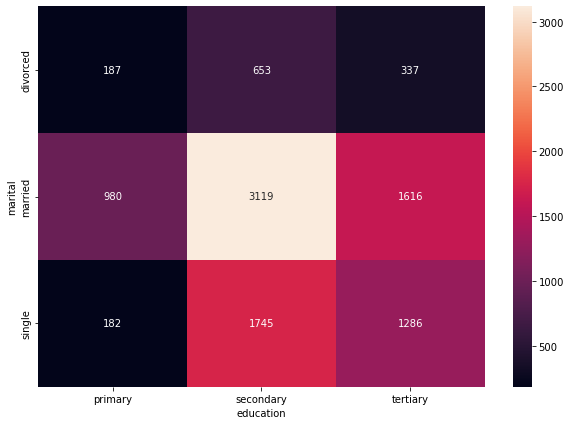

In [20]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_deposited = df.copy()
df_deposited['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_pivot = df_deposited.pivot_table(values='deposit', index = 'marital', columns='education', aggfunc='count')
fig = plt.subplots(figsize = (10, 7))
sns.heatmap(df_pivot, annot=True, fmt='d')

По тепловой карте видим, что несмотря на то, что клиенты в группах "в браке" и "среднее образование" открывают в процентном отношении меньше депозитов, за счет своего подавляющего количества они открывают их больше, чем комбинации других групп.

## Часть 3: преобразование данных

### Задание 1

In [21]:
# преобразуйте уровни образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])


### Задания 2 и 3

In [22]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['age_group'] = le.fit_transform(df['age_group'])

binary_columns = ['deposit', 'default', 'housing', 'loan']

for i in binary_columns:
    df[i] = df[i].apply(lambda x: 1 if x == 'yes' else 0)

### Задание 4

In [23]:
# создайте дамми-переменные
df = pd.get_dummies(data=df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

### Задания 5 и 6

<AxesSubplot:>

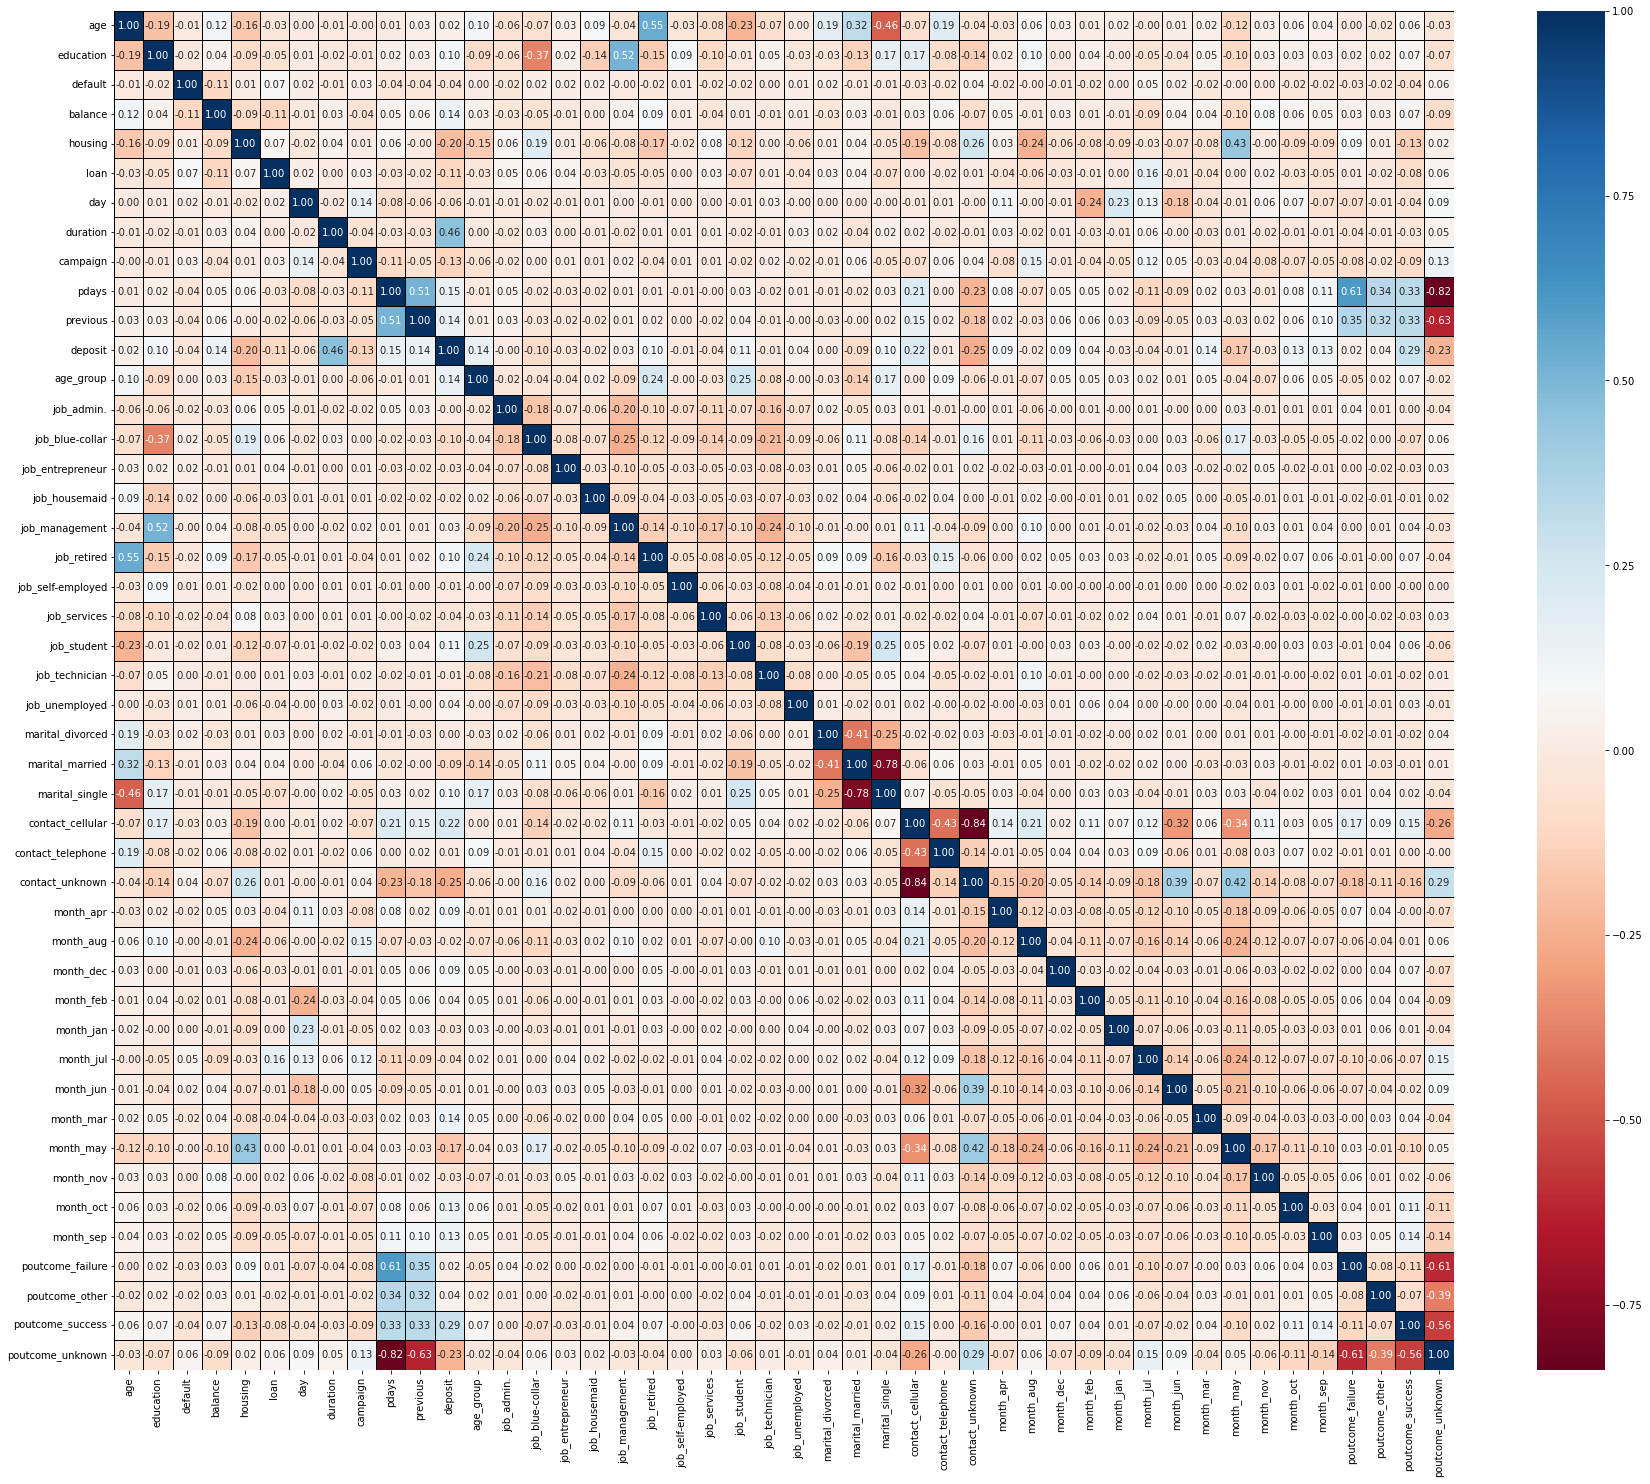

In [24]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.subplots(figsize = (30,25))
sns.heatmap(data = df.corr(), linewidths=1, linecolor='black', annot=True, fmt = '.2f', cmap='RdBu')

### Задания 7 и 8

In [25]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [26]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки: {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке равно {round(y_train.mean(),2)}')

Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке равно 0.46


### Задание 9

In [27]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
select_features = SelectKBest(score_func=f_classif, k=15)
select_features.fit_transform(X = X_train, y = y_train)
filter = select_features.get_support()
col_names = X_train.columns[filter]
X_train = X_train[col_names]
X_test = X_test[col_names]

### Задание 10

In [28]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns= col_names)

In [29]:
X_test['balance'].mean()

0.46823674223097655

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [30]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver= 'sag', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(f"Accuracy score: {round(metrics.accuracy_score(y_test, y_pred), 2)}")

Accuracy score: 0.81


### Задания 2,3,4

In [31]:
# обучите решающие деревья, настройте максимальную глубину
dec_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dec_tree.fit(X_train, y_train)
y_tree_train_pred = dec_tree.predict(X_train)
print(f"Accuracy score: {round(metrics.accuracy_score(y_train, y_tree_train_pred), 2)}")

Accuracy score: 1.0


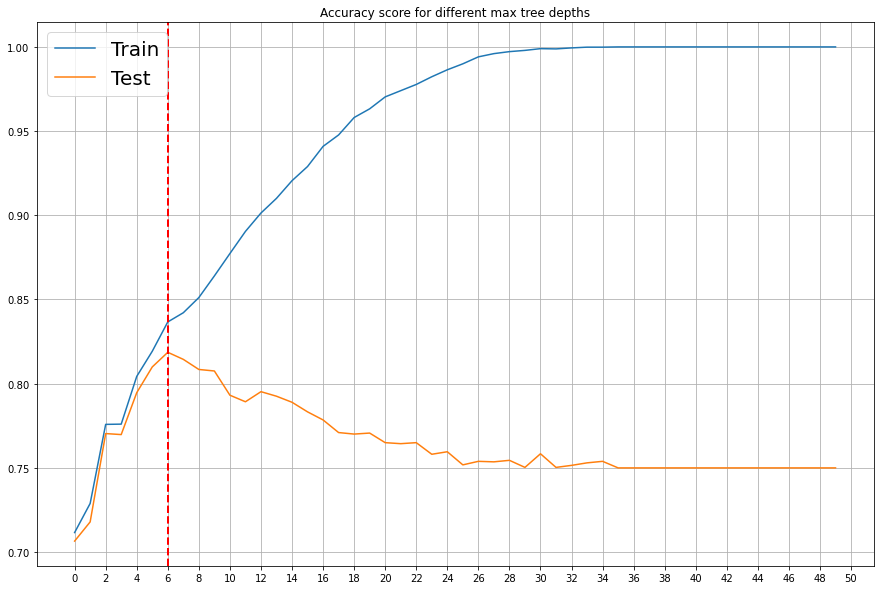

In [32]:
depth_list = np.linspace(1, 50, num = 50, dtype='int')
acc_score_list = [[],[]]
for depth in depth_list:
    model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=depth)
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc = metrics.accuracy_score(y_train, y_train_pred)
    test_acc = metrics.accuracy_score(y_test, y_test_pred)
    acc_score_list[0].append(train_acc)
    acc_score_list[1].append(test_acc)

acc_score_list = pd.DataFrame(acc_score_list).T.rename(columns={0: 'Train', 1: 'Test'})
fig, ax = plt.subplots(figsize = (15,10))
ax.set_xticks(range(0,101,2))
ax.grid(True)
ax.set_title('Accuracy score for different max tree depths')
plt.plot(acc_score_list['Train'], label = 'Train')
plt.plot(acc_score_list['Test'], label = 'Test')
ax.legend(fontsize = 20)
plt.axvline(x=6, color = 'red', linewidth = 2, linestyle = '--')

Видим, что максимальное значение метрики Accuracy достигается при максимальной глубине 6.

In [33]:
dec_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dec_tree.fit(X_train, y_train)
y_tree_test_pred = dec_tree.predict(X_test)
print(f"Accuracy score on test data: {round(metrics.accuracy_score(y_test, y_tree_test_pred), 2)}")

Accuracy score on test data: 0.81


### Задание 5

In [49]:
# подберите оптимальные параметры с помощью gridsearch
parameters = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
gs = GridSearchCV(param_grid=parameters, estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'))
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
print(f"F-1 score on test data: {round(metrics.f1_score(y_test, y_pred),2)}")
print(gs.best_params_)

F-1 score on test data: 0.8
{'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [44]:
# обучите на ваших данных случайный лес
rand_forest = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rand_forest.fit(X_train, y_train)
y_forest_test_pred = rand_forest.predict(X_test)
print(metrics.classification_report(y_test, y_forest_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [46]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gbc = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gbc.fit(X_train, y_train)
y_gbc_test_pred = gbc.predict(X_test)

print(metrics.classification_report(y_test, y_gbc_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



Видим, что градинтный бустинг дает несколко худший результат, чем случайный лес.

### Задание 4

In [51]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

reg = ensemble.StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression(random_state=42))
reg.fit(X_train, y_train)
y_stacking_pred = reg.predict(X_test)

print(metrics.classification_report(y_test, y_stacking_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.836     0.834     0.835      1790
           1      0.808     0.811     0.809      1545

    accuracy                          0.823      3335
   macro avg      0.822     0.822     0.822      3335
weighted avg      0.823     0.823     0.823      3335



### Задание 5

In [56]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_

['duration']
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 8,  5,  1, 12,  4, 13,  6, 14,  3,  7, 11,  9, 10,  2, 15])

### Задания 6,7,8

In [66]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)  
  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test))

  return score

study  = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-12-18 15:52:31,231] A new study created in memory with name: RandomForestClassifier
[I 2022-12-18 15:52:32,596] Trial 0 finished with value: 0.819496855345912 and parameters: {'n_estimators': 170, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.819496855345912.
[I 2022-12-18 15:52:33,197] Trial 1 finished with value: 0.8193303853442829 and parameters: {'n_estimators': 116, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.819496855345912.
[I 2022-12-18 15:52:33,882] Trial 2 finished with value: 0.8172043010752689 and parameters: {'n_estimators': 131, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.819496855345912.
[I 2022-12-18 15:52:34,382] Trial 3 finished with value: 0.8148618609082248 and parameters: {'n_estimators': 102, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.819496855345912.
[I 2022-12-18 15:52:35,625] Trial 4 finished with value: 0.8181246066708622 and parameters: {'n_estim

Наилучшие значения гиперпараметров {'n_estimators': 173, 'max_depth': 28, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.82


In [67]:
def optuna_rf_accuracy(trial):
    
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)  
  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.accuracy_score(y_test, model.predict(X_test))

  return score

study  = optuna.create_study(study_name="RandomForestClassifierAccuracy", direction="maximize")

study.optimize(optuna_rf_accuracy, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("Accuracy на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-12-18 15:52:48,389] A new study created in memory with name: RandomForestClassifierAccuracy
[I 2022-12-18 15:52:49,390] Trial 0 finished with value: 0.8308845577211394 and parameters: {'n_estimators': 184, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8308845577211394.
[I 2022-12-18 15:52:49,972] Trial 1 finished with value: 0.8266866566716642 and parameters: {'n_estimators': 121, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8308845577211394.
[I 2022-12-18 15:52:50,772] Trial 2 finished with value: 0.8290854572713643 and parameters: {'n_estimators': 141, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8308845577211394.
[I 2022-12-18 15:52:51,650] Trial 3 finished with value: 0.8269865067466267 and parameters: {'n_estimators': 188, 'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8308845577211394.
[I 2022-12-18 15:52:52,267] Trial 4 finished with value: 0.8308845577211394 and paramete

Наилучшие значения гиперпараметров {'n_estimators': 184, 'max_depth': 27, 'min_samples_leaf': 3}
Accuracy на обучающем наборе: 0.83


Заметно улучшение как f1, так и Accuracy score.